### A. Klasifikacija Vina po Stilu

Klasifikacija vina po stilu podrazumeva određivanje da li vino pripada kategoriji crnih ili belih vina na osnovu njegovih fizičko-hemijskih karakteristika. 

In [124]:
pip -q install seaborn ucimlrepo imbalanced-learn plotly torch

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, cohen_kappa_score, roc_auc_score
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\marva\OneDrive\matf\master\ni\NI_HistogramAlgorithms\.conda\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\marva\OneDrive\matf\master\ni\NI_HistogramAlgorithms\.conda\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\marva\OneDrive\matf\master\ni\NI_HistogramAlgorithms\.conda\L

#### 1. Korišćene Metrike

Za ocenu performansi klasifikacionih modela, koristili smo sledeće metrike:

- **Tačnost (Accuracy)**: Ova metrika meri procenat tačno klasifikovanih primera.
- **Izbalansirana tačnost (Balanced Accuracy)**: Korisna kada imamo nebalansirane skupove podataka.
- **F1 Skor (F1 Score)**: Harmonijska sredina između preciznosti i odziva.
- **Cohenova Kappa (Cohen’s Kappa)**: Metrika koja meri nivo saglasnosti između modela i stvarnih klasa.
- **ROC Kriva i AUC (Receiver Operating Characteristic and Area Under the Curve)**: Kvantifikuje sposobnost modela da razlikuje između klasa.


In [2]:
wine_quality = fetch_ucirepo(id=186)
print(wine_quality.variables)
df = wine_quality.data.original

                    name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_values  
0                     None  None             no  
1                     None  Non

In [3]:
X = df.iloc[:, :-2]  
y = df['color']
X_train_validation, X_test, y_train_validation, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, random_state=42, stratify=y_train_validation)
y_train = np.array(y_train).ravel()
y_train_validation = np.array(y_train_validation).ravel()
y_val = np.array(y_val).ravel()
y_test = np.array(y_test).ravel()

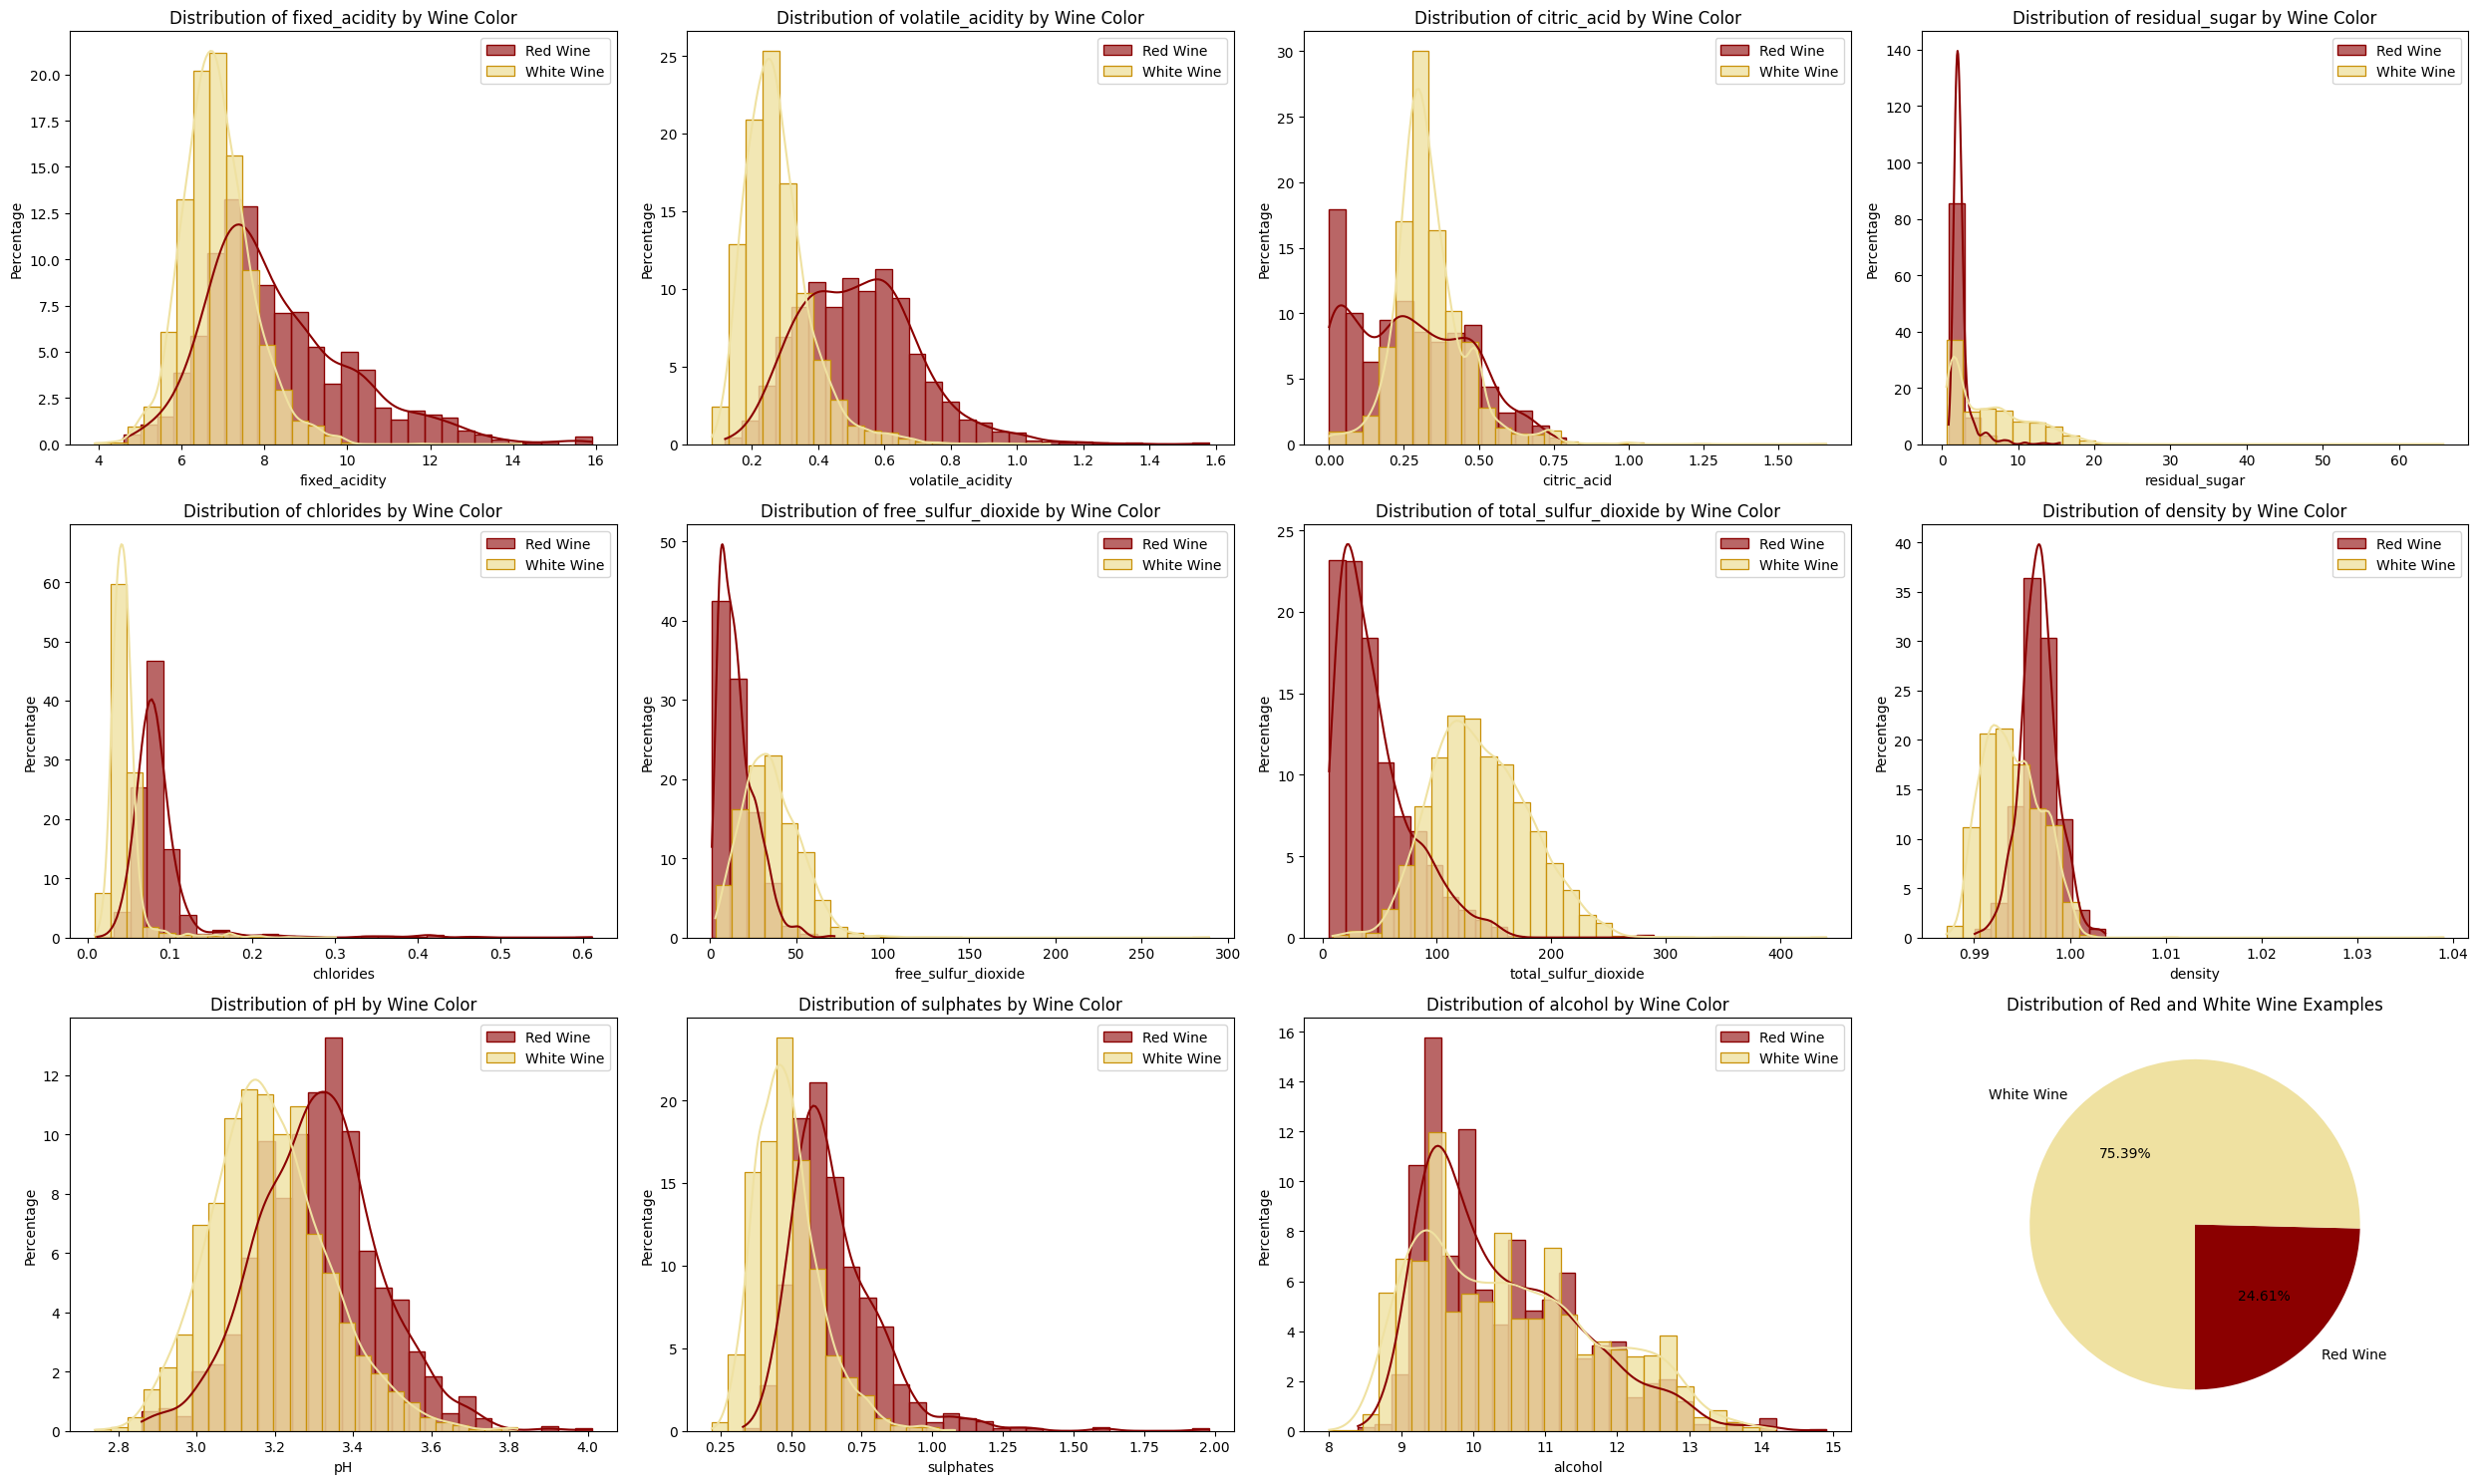

In [4]:
red_wine = X_train_validation[y_train_validation == 'red']
white_wine = X_train_validation[y_train_validation == 'white']


fig, axes = plt.subplots(3, 4, figsize=(25, 15))


axes = axes.flatten()

for i, column in enumerate(X_train_validation.columns):
    ax = axes[i]
    
    combined_min = min(red_wine[column].min(), white_wine[column].min())
    combined_max = max(red_wine[column].max(), white_wine[column].max())
    combined_range = combined_max - combined_min
    binwidth = combined_range / 30

    sb.histplot(red_wine[column], color='darkred', edgecolor='darkred', kde=True, label='Red Wine', alpha=0.6, stat='percent', binwidth=binwidth, ax=ax)
    sb.histplot(white_wine[column], color='#EFE1A1', edgecolor='#C9910A', kde=True, label='White Wine', alpha=0.8, stat='percent', binwidth=binwidth, ax=ax)
    
    ax.set_title(f'Distribution of {column} by Wine Color')
    ax.set_xlabel(column)
    ax.set_ylabel('Percentage')
    ax.legend()


ax_pie = axes[-1]

wine_counts = [len(red_wine), len(white_wine)]
wine_labels = ['Red Wine', 'White Wine']
wine_colors = ['darkred', '#EFE1A1']

ax_pie.pie(wine_counts, labels=wine_labels, colors=wine_colors, autopct='%.2f%%', startangle=-90)
ax_pie.set_title('Distribution of Red and White Wine Examples')

plt.tight_layout()
plt.show()

### Klasifikacija vrste vina

Modeli koje ćemo koristiti za klasifikaciju su:

- **Logistička regresija**
- **Naivni Bajes**
- **SVM**
- **Gausova diskriminantna analiza (GDA)**
- **Slučajne šume**

Svaki model će biti evaluiran pomoću metrika kao što su tačnost, izbalansirana tačnost, F1 skor, Cohenova Kappa i AUC ROC.


### Priprema podataka

Prvo ćemo pripremiti podatke za treniranje. Podatke ćemo podeliti na trening, validacioni i test skup. Zatim ćemo standardizovati karakteristike i konvertovati podatke u PyTorch tenzore. Tenzore ćemo koristiti za kreiranje DataLoader-a, koji će olakšati rad sa podacima tokom treniranja modela:


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor([0 if label == 'red' else 1 for label in y_train], dtype=torch.long).to(device)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor([0 if label == 'red' else 1 for label in y_val], dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor([0 if label == 'red' else 1 for label in y_test], dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)


### Definisanje Funkcije za Treniranje i Evaluaciju

Funkcija `train_and_evaluate` koristiće se za treniranje modela i evaluaciju njegovih performansi na validacionom skupu. Ova funkcija će takođe pratiti i beležiti gubitak na oba skupa tokom epoha, što će nam omogućiti da vizuelno pratimo napredak modela.


In [6]:
def train_and_evaluate(model, train_loader, val_loader, num_epochs=50, patience=5, min_delta=0.0001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    best_epoch = 0
    early_stop = False

    for epoch in range(num_epochs):
        if early_stop:
            print(f"Early stopping at epoch {epoch}.")
            break
        
        model.train()
        train_loss = 0
        
        for features, labels in train_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Early stopping condition
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_epoch = epoch
        elif epoch - best_epoch >= patience:
            early_stop = True
            
        if epoch % 10 == 0 or epoch == num_epochs-1 or early_stop:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_loss:.4f}')
            
    return train_losses, val_losses


In [19]:
def plot_loss(method, train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{method} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Logisticka regresija

Epoch [1/50], Train Loss: 0.6797, Validation Loss: 0.4914
Epoch [11/50], Train Loss: 0.0826, Validation Loss: 0.0972
Epoch [21/50], Train Loss: 0.0496, Validation Loss: 0.0726
Epoch [31/50], Train Loss: 0.0388, Validation Loss: 0.0664
Epoch [41/50], Train Loss: 0.0341, Validation Loss: 0.0652
Epoch [50/50], Train Loss: 0.0320, Validation Loss: 0.0656


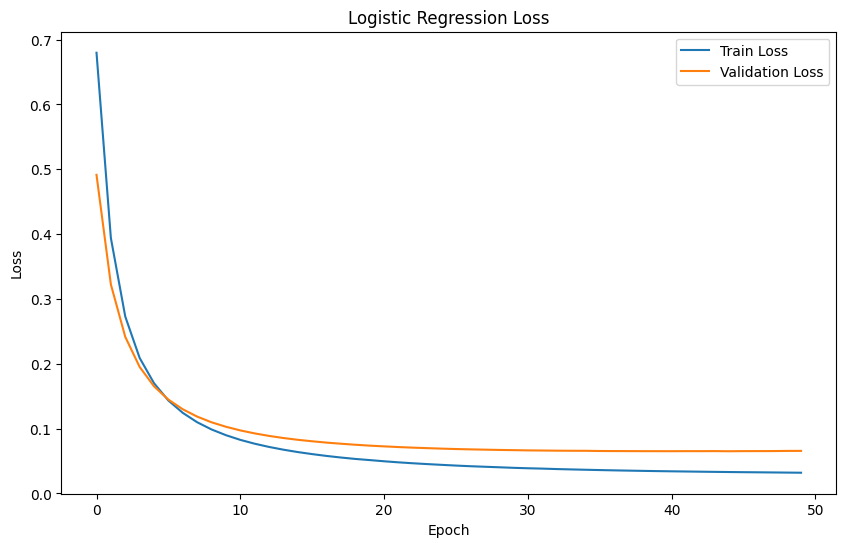

In [20]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

input_dim = X_train_tensor.shape[1]
output_dim = 2  

logistic_model = LogisticRegressionModel(input_dim, output_dim)
logistic_train_losses, logistic_val_losses = train_and_evaluate(logistic_model, train_loader, val_loader, num_epochs=50)

plot_loss("Logistic Regression", logistic_train_losses, logistic_val_losses)


Epoch [1/50], Train Loss: 0.6375, Validation Loss: 0.4704
Epoch [11/50], Train Loss: 0.0772, Validation Loss: 0.0896
Epoch [21/50], Train Loss: 0.0493, Validation Loss: 0.0691
Epoch [31/50], Train Loss: 0.0400, Validation Loss: 0.0642
Epoch [41/50], Train Loss: 0.0355, Validation Loss: 0.0634
Epoch [42/50], Train Loss: 0.0351, Validation Loss: 0.0635
Early stopping at epoch 42.


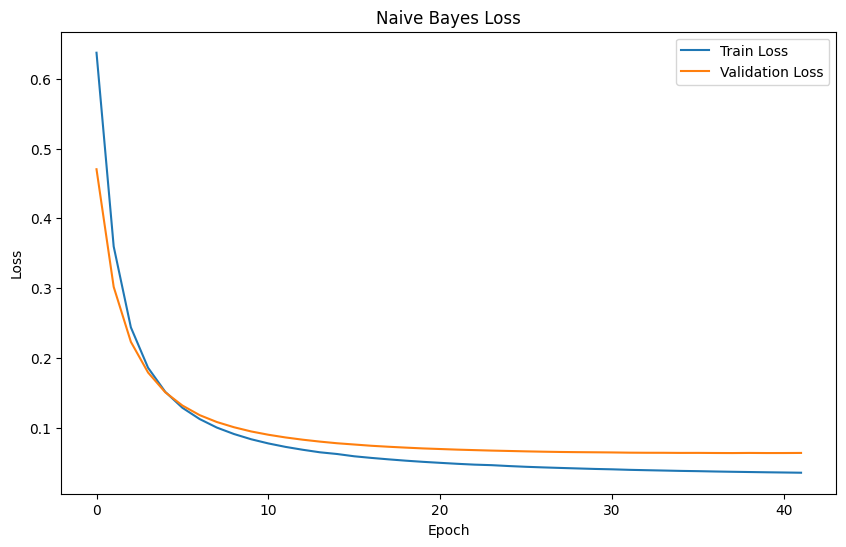

In [21]:
class NaiveBayesModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NaiveBayesModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

naive_bayes_model = NaiveBayesModel(input_dim, output_dim)
nb_train_losses, nb_val_losses = train_and_evaluate(naive_bayes_model, train_loader, val_loader, num_epochs=50)

plot_loss("Naive Bayes", nb_train_losses, nb_val_losses)


Epoch [1/100], Train Loss: 0.4445, Validation Loss: 0.3318
Epoch [11/100], Train Loss: 0.0733, Validation Loss: 0.0886
Epoch [21/100], Train Loss: 0.0472, Validation Loss: 0.0690
Epoch [31/100], Train Loss: 0.0383, Validation Loss: 0.0644
Epoch [41/100], Train Loss: 0.0341, Validation Loss: 0.0641
Epoch [42/100], Train Loss: 0.0339, Validation Loss: 0.0641
Early stopping at epoch 42.


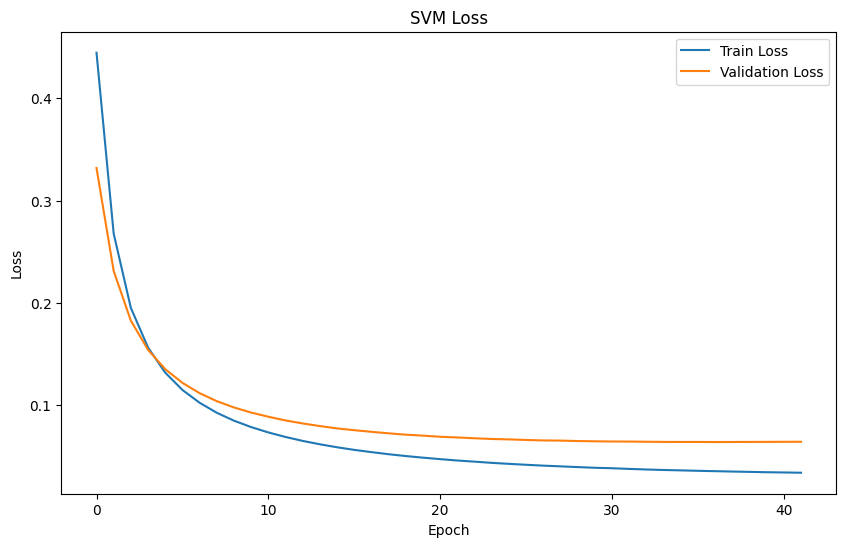

In [22]:
class SVMModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SVMModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

svm_model = SVMModel(input_dim, output_dim)
svm_train_losses, svm_val_losses = train_and_evaluate(svm_model, train_loader, val_loader, num_epochs=100)

plot_loss("SVM", svm_train_losses, svm_val_losses)


Epoch [1/50], Train Loss: 0.4506, Validation Loss: 0.2920
Epoch [11/50], Train Loss: 0.0280, Validation Loss: 0.0427
Epoch [21/50], Train Loss: 0.0199, Validation Loss: 0.0402
Early stopping at epoch 21.


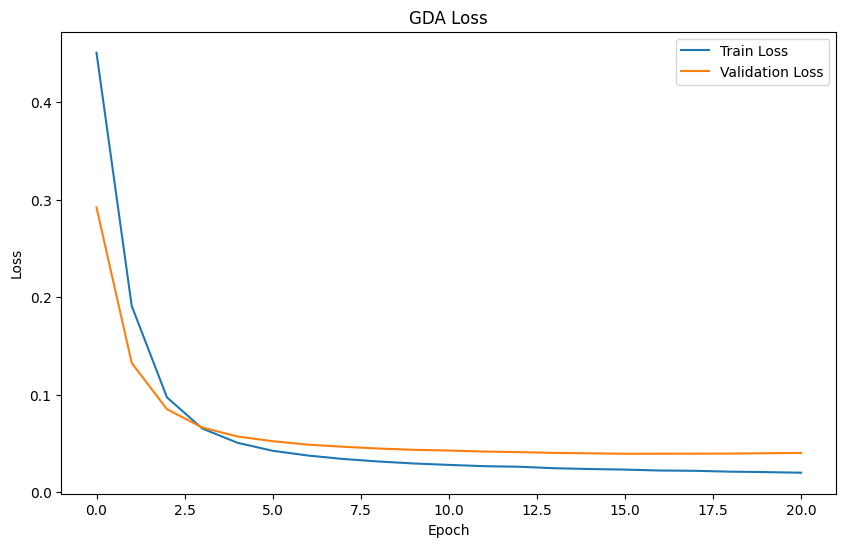

In [23]:
class GDAModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GDAModel, self).__init__()
        self.hidden = nn.Linear(input_dim, 10)
        self.output = nn.Linear(10, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.output(x)

gda_model = GDAModel(input_dim, output_dim)
gda_train_losses, gda_val_losses = train_and_evaluate(gda_model, train_loader, val_loader, num_epochs=50)

plot_loss("GDA", gda_train_losses, gda_val_losses)


Epoch [1/50], Train Loss: 0.2599, Validation Loss: 0.0569
Epoch [8/50], Train Loss: 0.0149, Validation Loss: 0.0353
Early stopping at epoch 8.


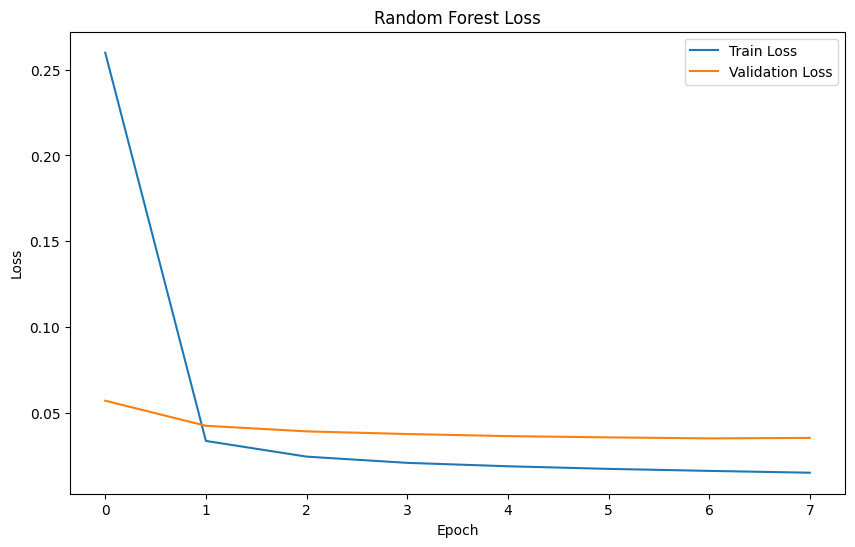

In [24]:
class RandomForestModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RandomForestModel, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 50)
        self.hidden2 = nn.Linear(50, 20)
        self.output = nn.Linear(20, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        return self.output(x)

rf_model = RandomForestModel(input_dim, output_dim)
rf_train_losses, rf_val_losses = train_and_evaluate(rf_model, train_loader, val_loader, num_epochs=50, patience=1) ## komentar zasto 2

plot_loss("Random Forest", rf_train_losses, rf_val_losses)


### Zaključak

U ovoj beležnici implementirali smo nekoliko modela za klasifikaciju vina kao crveno ili belo korišćenjem PyTorch-a. Pratili smo i vizuelizovali gubitak na trening i validacionom skupu tokom epoha za svaki model. Na osnovu ovih rezultata, možemo proceniti koji model najbolje performira u smislu stabilnosti treniranja i generalizacije na validacioni skup.

Dalji koraci mogu uključivati optimizaciju hiperparametara, izbor modela, i evaluaciju na test skupu.


## Metrike

In [12]:
def calculate_metrics(model, X_val_tensor, y_val_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_val_tensor)
        _, predicted = torch.max(outputs, 1)
    
    y_true = y_val_tensor.tolist()
    y_pred = predicted.tolist()
    
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    return {
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_accuracy,
        'F1 Score': f1,
        'Cohen\'s Kappa': kappa,
        'AUC ROC': auc
    }


In [13]:
results = []

logistic_metrics = calculate_metrics(logistic_model, X_val_tensor, y_val_tensor)
logistic_metrics['Model'] = 'Logistička Regresija'
results.append(logistic_metrics)

nb_metrics = calculate_metrics(naive_bayes_model, X_val_tensor, y_val_tensor)
nb_metrics['Model'] = 'Naivni Bajes'
results.append(nb_metrics)

svm_metrics = calculate_metrics(svm_model, X_val_tensor, y_val_tensor)
svm_metrics['Model'] = 'SVM'
results.append(svm_metrics)

gda_metrics = calculate_metrics(gda_model, X_val_tensor, y_val_tensor)
gda_metrics['Model'] = 'GDA'
results.append(gda_metrics)

rf_metrics = calculate_metrics(rf_model, X_val_tensor, y_val_tensor)
rf_metrics['Model'] = 'Slučajna Šuma'
results.append(rf_metrics)


In [14]:
results_df = pd.DataFrame(results)

print("Uporedni rezultati modela:")
print(results_df)


Uporedni rezultati modela:
   Accuracy  Balanced Accuracy  F1 Score  Cohen's Kappa   AUC ROC  \
0  0.990769           0.986862  0.993882       0.975093  0.986862   
1  0.990769           0.986862  0.993882       0.975093  0.986862   
2  0.990769           0.986862  0.993882       0.975093  0.986862   
3  0.992821           0.989626  0.995241       0.980628  0.989626   
4  0.993846           0.988903  0.995929       0.983325  0.988903   

                  Model  
0  Logistička Regresija  
1          Naivni Bajes  
2                   SVM  
3                   GDA  
4         Slučajna Šuma  


### Zaključak

Zaključujemo da metoda slučajne šume postiže najbolje rezultate na validacionom skupu u svim metrikama koje smo koristili. Stoga ćemo ovaj model izabrati kao finalni. 

## Retreniranje na trening i validacionom skupu

Da bismo maksimalno iskoristili dostupne podatke, ponovo ćemo obučiti model Slučajne Šume koristeći objedinjeni skup za trening i validaciju. Nakon toga, evaluiraćemo model na test skupu kako bismo procenili njegovu performansu na neviđenim podacima.

In [33]:
X_train_val_combined = torch.cat([X_train_tensor, X_val_tensor], dim=0)
y_train_val_combined = torch.cat([y_train_tensor, y_val_tensor], dim=0)

rf_combined_model = RandomForestModel(input_dim, output_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rf_combined_model.parameters(), lr=0.001)

num_epochs = 50
rf_combined_model.train()

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = rf_combined_model(X_train_val_combined)
    loss = criterion(outputs, y_train_val_combined)
    
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/50], Loss: 0.7688
Epoch [2/50], Loss: 0.7590
Epoch [3/50], Loss: 0.7493
Epoch [4/50], Loss: 0.7398
Epoch [5/50], Loss: 0.7304
Epoch [6/50], Loss: 0.7210
Epoch [7/50], Loss: 0.7118
Epoch [8/50], Loss: 0.7025
Epoch [9/50], Loss: 0.6932
Epoch [10/50], Loss: 0.6839
Epoch [11/50], Loss: 0.6746
Epoch [12/50], Loss: 0.6651
Epoch [13/50], Loss: 0.6556
Epoch [14/50], Loss: 0.6460
Epoch [15/50], Loss: 0.6362
Epoch [16/50], Loss: 0.6263
Epoch [17/50], Loss: 0.6163
Epoch [18/50], Loss: 0.6061
Epoch [19/50], Loss: 0.5957
Epoch [20/50], Loss: 0.5851
Epoch [21/50], Loss: 0.5744
Epoch [22/50], Loss: 0.5635
Epoch [23/50], Loss: 0.5523
Epoch [24/50], Loss: 0.5410
Epoch [25/50], Loss: 0.5296
Epoch [26/50], Loss: 0.5179
Epoch [27/50], Loss: 0.5062
Epoch [28/50], Loss: 0.4942
Epoch [29/50], Loss: 0.4822
Epoch [30/50], Loss: 0.4701
Epoch [31/50], Loss: 0.4579
Epoch [32/50], Loss: 0.4456
Epoch [33/50], Loss: 0.4333
Epoch [34/50], Loss: 0.4211
Epoch [35/50], Loss: 0.4088
Epoch [36/50], Loss: 0.3965
E

In [45]:
results = calculate_metrics(rf_combined_model, X_test_tensor,y_test_tensor)
print(f'Test Accuracy of the Random Forest model:\n\n{pd.Series(results)}')

Test Accuracy of the Random Forest model:

Accuracy             0.987077
Balanced Accuracy    0.978801
F1 Score             0.991460
Cohen's Kappa        0.964913
AUC ROC              0.978801
dtype: float64
